In [1]:
from data_cleaning import Open, Stream, MakeMIDI, ChordEval
from music21 import chord, note, stream, clef, meter
import os
import numpy as np
import torch

In [2]:
mid_file1 = os.path.join(os.getcwd(), "progression1.mid")
midi_data1 = Open.open_midi(mid_file1)
mid_file2 = os.path.join(os.getcwd(), "progression2.mid")
midi_data2 = Open.open_midi(mid_file2)

In [24]:
mid_file_offset = os.path.join(os.getcwd(), "offset chord.mid")
midi_data_offset = Open.open_midi(mid_file_offset)

In [3]:
concatenated_array = []

In [5]:
for i, part in enumerate(midi_data2.parts):
    for element in part.recurse():
        if isinstance(element, chord.Chord):
            concatenated_array.append(element)

In [6]:
all_chords = []
for chord in concatenated_array:
    chord_arr = []
    for notes in chord:
        chord_arr.append(notes.pitch.ps)
    all_chords.append(chord_arr)

In [37]:
len(all_chords)

186

In [43]:
max(len(chord) for chord in all_chords)

6

In [44]:
min(len(chord) for chord in all_chords)

3

In [ ]:
sorted(b.items(), key=lambda kv: -kv[1])

In [7]:
N = torch.zeros((129, 129), dtype=torch.int32)

In [8]:
flattened_list = [int(element) for sublist in all_chords for element in sublist]

In [51]:
notes = sorted(set(flattened_list))

In [52]:
len(notes)

23

In [57]:
n_to_i = {s: s for i, s in enumerate(notes)}
n_to_i["."] = 128

In [63]:
i_to_n = {}

for n in notes:
    n_temp = note.Note(n)
    i_to_n[n] = n_temp.nameWithOctave

i_to_n[128] = "."
print(i_to_n)

{36: 'C2', 40: 'E2', 41: 'F2', 43: 'G2', 45: 'A2', 47: 'B2', 48: 'C3', 50: 'D3', 52: 'E3', 53: 'F3', 55: 'G3', 57: 'A3', 58: 'B-3', 59: 'B3', 60: 'C4', 62: 'D4', 63: 'E-4', 64: 'E4', 65: 'F4', 67: 'G4', 69: 'A4', 71: 'B4', 72: 'C5', 128: '.'}


In [64]:
n_to_i, i_to_n

({36: 36,
  40: 40,
  41: 41,
  43: 43,
  45: 45,
  47: 47,
  48: 48,
  50: 50,
  52: 52,
  53: 53,
  55: 55,
  57: 57,
  58: 58,
  59: 59,
  60: 60,
  62: 62,
  63: 63,
  64: 64,
  65: 65,
  67: 67,
  69: 69,
  71: 71,
  72: 72,
  '.': 128},
 {36: 'C2',
  40: 'E2',
  41: 'F2',
  43: 'G2',
  45: 'A2',
  47: 'B2',
  48: 'C3',
  50: 'D3',
  52: 'E3',
  53: 'F3',
  55: 'G3',
  57: 'A3',
  58: 'B-3',
  59: 'B3',
  60: 'C4',
  62: 'D4',
  63: 'E-4',
  64: 'E4',
  65: 'F4',
  67: 'G4',
  69: 'A4',
  71: 'B4',
  72: 'C5',
  128: '.'})

In [12]:
for chord in all_chords:
    c_bigram = ["."] + chord + ["."]
    for c1, c2 in zip(c_bigram, c_bigram[1:]):
        ix1 = ntoi[c1]
        ix2 = ntoi[c2]
        N[ix1, ix2] += 1

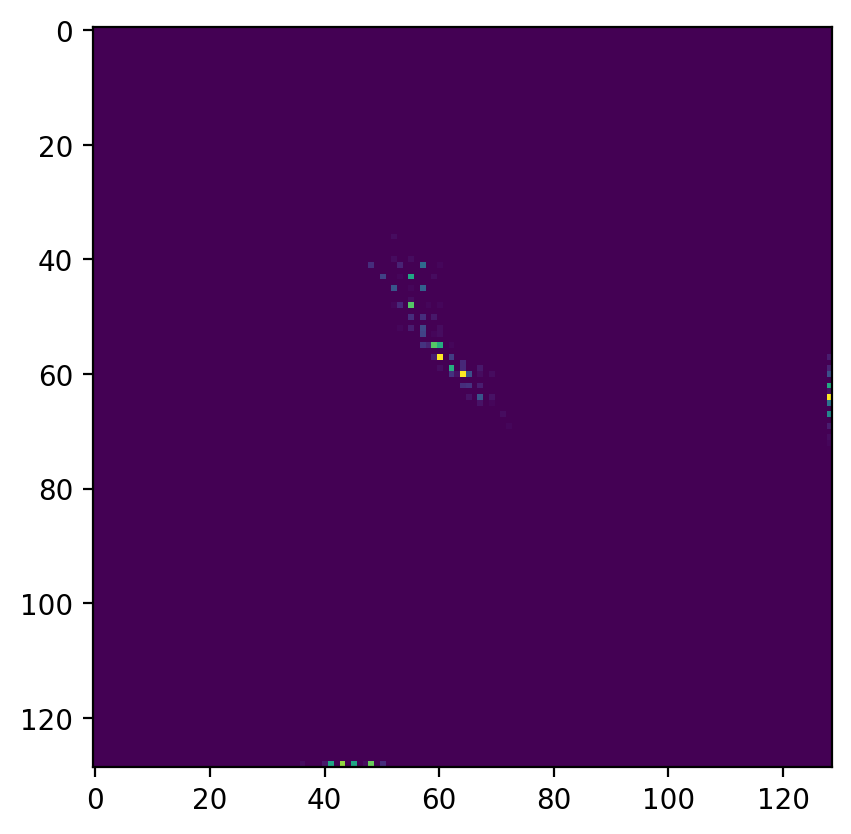

In [13]:
import matplotlib.pyplot as plt

plt.imshow(N)

# Sample the probabilities


In [28]:
P = N.float()
P /= P.sum(1, keepdim=True)

In [30]:
g = torch.Generator().manual_seed(57485)
midi_n = 0
numofc = 0
while True:
    p = P[midi_n]
    if not torch.isnan(p).any().item():
        midi_n = torch.multinomial(
            p, num_samples=1, replacement=True, generator=g
        ).item()
        if not midi_n == 128:
            new_note = note.Note(midi_n)
            print(new_note.pitch)
    else:
        midi_n += 1
    if midi_n == 128:
        print("__")
        numofc += 1
        if numofc == 4:
            break

E3
A3
C4
F4
__
C3
G3
C4
E4
__
A2
A3
C4
D4
__
F2
A3
__


# Evaluating the Quality of the model


In [40]:
log_likelihood = 0.0
n = 0
for chord in all_chords:
    c_bigram = ["."] + chord + ["."]
    for c1, c2 in zip(c_bigram, c_bigram[1:]):
        ix1 = ntoi[c1]
        ix2 = ntoi[c2]
        p = P[ix1, ix2]
        logprob = torch.log(p)
        log_likelihood += logprob
        n += 1

nll = -log_likelihood
# nll/=n
print(nll / n)

tensor(1.0509)


# Making a Neural Network


## Creating a training set


In [66]:
xs, ys = [], []

for c in all_chords[:1]:
    ns = ["."] + c + ["."]
    for n1, n2 in zip(ns, ns[1:]):
        ix1 = ntoi[n1]
        ix2 = ntoi[n2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [67]:
xs, ys

(tensor([128,  48,  55,  60,  62,  64]),
 tensor([ 48,  55,  60,  62,  64, 128]))

## One Hot Encoding


In [82]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=129).float()
yenc = F.one_hot(ys, num_classes=129).float()

In [ ]:
xenc, yenc

In [89]:
W = torch.randn((129, 129))
logits = xenc @ W
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)

In [99]:
probs[0]

tensor([0.0075, 0.0015, 0.0087, 0.0087, 0.0010, 0.0280, 0.0010, 0.0025, 0.0052,
        0.0142, 0.0263, 0.0026, 0.0012, 0.0046, 0.0025, 0.0029, 0.0050, 0.0030,
        0.0171, 0.0091, 0.0032, 0.0030, 0.0084, 0.0145, 0.0209, 0.0035, 0.0211,
        0.0078, 0.0018, 0.0031, 0.0029, 0.0126, 0.0053, 0.0037, 0.0037, 0.0051,
        0.0014, 0.0044, 0.0369, 0.0025, 0.0068, 0.0021, 0.0018, 0.0217, 0.0048,
        0.0099, 0.0509, 0.0064, 0.0013, 0.0046, 0.0039, 0.0056, 0.0067, 0.0051,
        0.0051, 0.0019, 0.0154, 0.0083, 0.0029, 0.0079, 0.0048, 0.0042, 0.0021,
        0.0038, 0.0074, 0.0012, 0.0153, 0.0110, 0.0022, 0.0048, 0.0132, 0.0162,
        0.0032, 0.0154, 0.0043, 0.0019, 0.0002, 0.0292, 0.0002, 0.0073, 0.0111,
        0.0007, 0.0142, 0.0051, 0.0056, 0.0026, 0.0100, 0.0068, 0.0070, 0.0019,
        0.0040, 0.0023, 0.0150, 0.0068, 0.0072, 0.0168, 0.0081, 0.0008, 0.0014,
        0.0039, 0.0016, 0.0028, 0.0033, 0.0307, 0.0012, 0.0033, 0.0069, 0.0114,
        0.0028, 0.0240, 0.0003, 0.0036, 

In [98]:
probs[0].max()

tensor(0.0509)

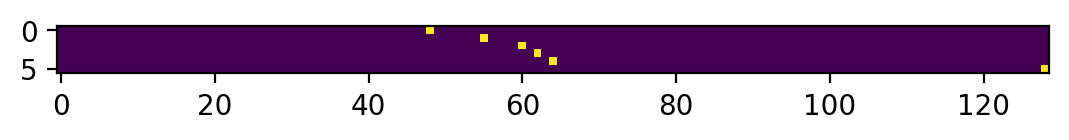

In [78]:
plt.imshow(yenc)

# Finding all types of elements in a part


In [22]:
for part in midi_data_offset.parts:
    chords_array = []
    for idx, element in enumerate(part.recurse()):
        if isinstance(element, stream.Measure):
            print(idx, element)
        elif isinstance(element, clef.TrebleClef):
            print(idx, element)
        elif isinstance(element, meter.TimeSignature):
            print(idx, element)
        elif isinstance(element, chord.Chord):
            print(
                "CHord",
                [
                    [
                        n.pitch.ps,
                        n.volume.velocity,
                        n.duration.quarterLength,
                        n.duration.type,
                        n.offset,
                    ]
                    for n in element.notes
                ],
            )
        elif isinstance(element, note.Rest):
            print(idx, element)

0 <music21.stream.Measure 1 offset=0.0>
2 <music21.clef.TrebleClef>
3 <music21.meter.TimeSignature 4/4>
CHord [[60.0, 102, 1.0, 'quarter', 0.0], [65.0, 102, 1.0, 'quarter', 0.0]]
5 <music21.stream.Measure 2 offset=4.0>
6 <music21.note.Rest quarter>
CHord [[60.0, 100, 1.0, 'quarter', 0.0], [67.0, 102, 1.0, 'quarter', 0.0]]
8 <music21.note.Rest dotted-eighth>


In [184]:
for i, part in enumerate(midi_data_offset.parts):
    chords_array = []
    for idx, element in enumerate(part.recurse()):
        print(idx, element)
        if isinstance(element, chord.Chord):
            # if isinstance(part.recurse()[idx-1],)
            chord_array = [element]
            # for i, n in enumerate(element):
            #     chord_array.append(
            #         [int(n.pitch.ps), n.volume.velocity, n.duration.quarterLength, n.offset, 0])
            chords_array.append(chord_array)
    if chords_array:
        concatenated_array.append(chords_array)

0 <music21.stream.Measure 1 offset=0.0>
1 
2 <music21.clef.TrebleClef>
3 <music21.meter.TimeSignature 4/4>
4 <music21.chord.Chord C4 F4>
5 <music21.stream.Measure 2 offset=4.0>
6 <music21.note.Rest quarter>
7 <music21.chord.Chord C4 G4>
8 <music21.note.Rest dotted-eighth>
9 <music21.bar.Barline type=final>


In [185]:
concatenated_array

[[[<music21.chord.Chord C4 F4>], [<music21.chord.Chord C4 G4>]]]

# Outputting a MIDI file


In [158]:
s = stream.Score()

In [166]:
for each_file in concatenated_array:
    for chords in each_file:
        chord_arr = []
        for each_chord in chords:
            n = note.Note(each_chord[0])
            n.volume.velocity = each_chord[1]
            n.duration.quarterLength = each_chord[2]
            n.offset = each_chord[3]
            chord_arr.append(n)

        c = chord.Chord(chord_arr)
        s.append(c)

In [167]:
s

<music21.stream.Score 0x1ef6dc803d0>

In [168]:
s.write("midi", "output_file.mid")

'output_file.mid'